<a href="https://colab.research.google.com/github/Imran012x/Transfer-Models/blob/main/HILSHA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Co-Lab -->> Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')



# # Upload a file
# uploaded = files.upload()
# # Get the file name
# file_name = list(uploaded.keys())[0]
# print(f"Uploaded file: {file_name}")



# import zipfile
# import os
# # with zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_224_11k.zip', 'r') as zip_ref:
# #     zip_ref.extractall('')
# with zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip', 'r') as zip_ref:
#     zip_ref.extractall('')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocess and Save

In [2]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import zipfile

# Check GPU availability
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

# Define fish classes and dataset paths
fish_classes = ['ilish', 'chandana', 'sardin', 'sardinella', 'punctatus'] #0,1,2,3,4
zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip').extractall('/content/.hidden_fish')
data_dir = '/content/.hidden_fish'

image_limits = {
    'ilish': 3000,
    'chandana': 1185,
    'sardin': 2899,
    'sardinella': 370,
    'punctatus': 953
}

# Settings
total_images = sum(image_limits.values())
batch_size = 100
num_threads = 4


# Output paths
output_dir = '/content/drive/MyDrive/Hilsha'
os.makedirs(output_dir, exist_ok=True)
labels_file = os.path.join(output_dir, 'Y_labels.npy')
xdata_file = os.path.join(output_dir, 'X_data.npy')

save_lock = threading.Lock()  # for thread-safe writes -> Prevents race conditions when multiple threads write to the same list.

# Function to gather image paths
def get_image_paths(class_name, max_images):
    path = os.path.join(data_dir, class_name)
    files = sorted(os.listdir(path))
    random.shuffle(files)
    return [os.path.join(path, f) for f in files[:max_images]]

# Load and preprocess batch
def load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx):
    end_idx = min(start_idx + batch_size, len(image_paths))
    batch_paths = image_paths[start_idx:end_idx]
    batch_images = []

    for img_path in batch_paths:
        img = Image.open(img_path).resize((224, 224)).convert('RGB')
        img_tensor = torch.tensor(np.array(img), dtype=torch.uint8).permute(2, 0, 1)  # C x H x W
        batch_images.append(img_tensor)

    batch_tensor = torch.stack(batch_images)  # B x C x H x W
    batch_labels = np.full((len(batch_images),), class_idx, dtype=np.int32)
    return batch_tensor, batch_labels

# Process one batch and return tensors & labels (no file saving)
def process_batch(image_paths, start_idx, batch_size, class_idx):
    return load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx)

def preprocess_and_save_all(overwrite=True):
    if os.path.exists(labels_file) and os.path.exists(xdata_file) and not overwrite:
        print("Preprocessed data already exists. Set overwrite=True to reprocess.")
        return

    all_images = []
    all_labels = []
    processed_count = 0

    for idx, class_name in enumerate(fish_classes):
        print(f"\nProcessing class: {class_name}")
        image_paths = get_image_paths(class_name, image_limits[class_name])
        total_batches = (len(image_paths) + batch_size - 1) // batch_size
        #It ensures ceiling division — rounding up, not down.
        # Normal division: 103 / 20 = 5.15 → floor division // 20 = 5 (❌ missing last 3 images)
        # This trick: (103 + 20 - 1) // 20 = 122 // 20 = 6 ✅

        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = []
            for start in range(0, len(image_paths), batch_size):
                futures.append(executor.submit(process_batch, image_paths, start, batch_size, idx))

            for future in tqdm(as_completed(futures), total=total_batches, desc=class_name):#taqaddum (تقدّم) – Arabic for "progress".
                # futures: List of tasks (from ThreadPoolExecutor or ProcessPoolExecutor).
                # as_completed(futures): Yields each future as it finishes (not in order).

                batch_tensor, batch_labels = future.result()
                with save_lock: #Locks this section so that only one thread can update the shared lists safely.
                    all_images.append(batch_tensor)
                    all_labels.append(batch_labels)
                    processed_count += batch_tensor.size(0)
                    print(f"Processed batch with {batch_tensor.size(0)} images, total processed: {processed_count}/{total_images}")
                gc.collect()

    # Combine all tensors and labels
    X = torch.cat(all_images, dim=0).numpy()
    Y = np.concatenate(all_labels, axis=0)

    # Save final arrays
    np.save(xdata_file, X, allow_pickle=False)#Malicious .npy -> import os;os.system("rm -rf /")  # ← Dangerous command
    np.save(labels_file, Y, allow_pickle=False)

    print(f"\n✅ Done! Saved {processed_count} images in {xdata_file}")
    print(f"X_data shape: {X.shape}, Y_labels shape: {Y.shape}")

    if processed_count != total_images:
        raise ValueError(f"Expected {total_images} images, but processed {processed_count}")

# Run preprocessing and save directly to X_data.npy and Y_labels.npy
preprocess_and_save_all(overwrite=True)


GPU Available: True
GPU Name: NVIDIA L4

Processing class: ilish


ilish:   0%|          | 0/30 [00:32<?, ?it/s]


KeyboardInterrupt: 

####DATA LOADING....

In [2]:
import os
import numpy as np
import torch

# Your data path
output_dir = '/content/drive/MyDrive/Hilsha'
data_file = os.path.join(output_dir, 'X_data.npy')
labels_file = os.path.join(output_dir, 'Y_labels.npy')

# Readable size format
def sizeof_fmt(num, suffix='B'):
    for unit in ['', 'K', 'M', 'G', 'T']:
        if abs(num) < 1024.0:
            return f"{num:3.2f} {unit}{suffix}"
        num /= 1024.0
    return f"{num:.2f} T{suffix}"

# Main loader
def load_preprocessed_data(as_torch=True, normalize=True, to_device=None):
    # Check file existence #cpu,cuda (CUDA stands for Compute Unified Device Architecture.)
    for path in [data_file, labels_file]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing: {path}")

    # Print file sizes
    print(f"📁 X_data.npy: {sizeof_fmt(os.path.getsize(data_file))}")
    print(f"📁 Y_labels.npy: {sizeof_fmt(os.path.getsize(labels_file))}")

    # Load with mmap
    X = np.load(data_file, mmap_mode='r')
    Y = np.load(labels_file, mmap_mode='r')

    print(f"✅ X shape: {X.shape}, dtype: {X.dtype}")
    print(f"✅ Y shape: {Y.shape}, dtype: {Y.dtype}")

    # Sanity check
    if len(X) != len(Y):
        raise ValueError("Mismatch between number of samples in X and Y")

    # Convert to torch
    if as_torch:
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)

        if normalize and X.dtype == torch.uint8:
            X = X.float() / 255.0

        if to_device:
            X = X.to(to_device)
            Y = Y.to(to_device)

        print(f"🧠 Torch tensors ready on {to_device or 'CPU'}")

    return X, Y

# 🔁 Example call
X, Y = load_preprocessed_data(
    as_torch=True,
    normalize=True,
    to_device='cuda' if torch.cuda.is_available() else 'cpu'
)

📁 X_data.npy: 1.18 GB
📁 Y_labels.npy: 32.96 KB
✅ X shape: (8407, 3, 224, 224), dtype: uint8
✅ Y shape: (8407,), dtype: int32


/tmp/ipython-input-2614331559.py:42: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  X = torch.from_numpy(X)


🧠 Torch tensors ready on cuda


🚀 GPU: NVIDIA L4
📊 Original data: (8407, 3, 224, 224), Classes: [3000 1185 2899  370  953]


[I 2025-08-17 21:10:42,405] A new study created in memory with name: no-name-4d81a2b4-e906-47db-8072-f76481631b17


📊 Balanced data: (15000, 3, 224, 224), Classes: [3000 3000 3000 3000 3000]


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]
[I 2025-08-17 21:26:45,947] Trial 0 finished with value: 0.20000000000000004 and parameters: {'learning_rate': 0.0005, 'weight_decay': 1e-05, 'dropout_rate': 0.2, 'optimizer': 'adam', 'scheduler': 'plateau', 'augmentation_strength': 'light', 'backbone': 'resnet50'}. Best is trial 0 with value: 0.20000000000000004.
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 225MB/s]
[I 2025-08-17 21:39:42,083] Trial 1 finished with value: 0.4640666666666666 and parameters: {'learning_rate': 0.002, 'weight_decay': 0.001, 'dropout_rate': 0.3, 'optimizer': 'adamw', 'scheduler': 'plateau', 'augmentation_strength': 'heavy', 'backbone': 'efficientnet_b0'}. Best is

🏆 Best Hyperparameters: {'learning_rate': 0.0005, 'weight_decay': 0.001, 'dropout_rate': 0.3, 'optimizer': 'adam', 'scheduler': 'plateau', 'augmentation_strength': 'medium', 'backbone': 'efficientnet_b0'}
Epoch 1: Train Acc: 0.8696, Val Acc: 0.1957
Epoch 2: Train Acc: 0.9234, Val Acc: 0.2730
Epoch 3: Train Acc: 0.9341, Val Acc: 0.0007
Epoch 4: Train Acc: 0.9394, Val Acc: 0.4103
Epoch 5: Train Acc: 0.9434, Val Acc: 0.1837
Epoch 6: Train Acc: 0.9478, Val Acc: 0.1600
Epoch 7: Train Acc: 0.9453, Val Acc: 0.1770
Epoch 8: Train Acc: 0.9483, Val Acc: 0.0090
Epoch 9: Train Acc: 0.9517, Val Acc: 0.0000
Epoch 10: Train Acc: 0.9553, Val Acc: 0.0240
Epoch 11: Train Acc: 0.9775, Val Acc: 0.4077
Epoch 12: Train Acc: 0.9832, Val Acc: 0.5223
Epoch 13: Train Acc: 0.9848, Val Acc: 0.0440
Epoch 14: Train Acc: 0.9848, Val Acc: 0.6173
Epoch 15: Train Acc: 0.9871, Val Acc: 0.3527
Epoch 16: Train Acc: 0.9902, Val Acc: 0.6290
Epoch 17: Train Acc: 0.9892, Val Acc: 0.5627
Epoch 18: Train Acc: 0.9886, Val Acc: 0

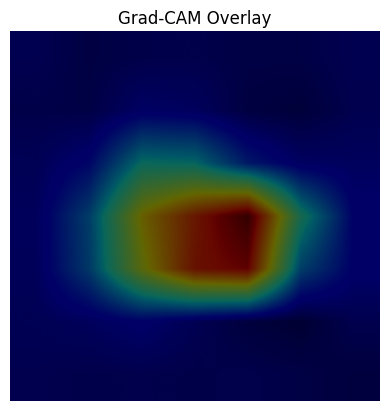

In [13]:
"""
Enhanced Fish Species Classification with Hyperparameter Tuning & XAI
=====================================================================
Author: Enhanced Fish Classification System
Version: 2.0 - Journal Ready
"""

import os, warnings, cv2, json, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from typing import Dict, List
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import albumentations as A
from albumentations.pytorch import ToTensorV2
import optuna

warnings.filterwarnings("ignore")
plt.style.use('default')

# =========================
# CONFIGURATION & SETUP
# =========================
class Config:
    DATA_FILE = '/content/drive/MyDrive/Hilsha/X_data.npy'
    LABELS_FILE = '/content/drive/MyDrive/Hilsha/Y_labels.npy'
    OUTPUT_DIR = '/content/outputs'
    INPUT_SIZE = 224
    NUM_CLASSES = 5
    CLASS_LABELS = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']
    BATCH_SIZE = 32
    MAX_EPOCHS = 50
    PATIENCE = 10
    HP_SPACE = {
        'learning_rate': [1e-4, 5e-4, 1e-3, 2e-3],
        'weight_decay': [1e-5, 1e-4, 1e-3],
        'dropout_rate': [0.2, 0.3, 0.4, 0.5],
        'optimizer': ['adam', 'adamw', 'sgd'],
        'scheduler': ['cosine', 'step', 'plateau'],
        'augmentation_strength': ['light', 'medium', 'heavy']
    }
    K_FOLDS = 5
    TEST_SIZE = 0.2
    SEED = 42
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    N_TRIALS = 30

def setup_environment():
    torch.manual_seed(Config.SEED)
    np.random.seed(Config.SEED)
    random.seed(Config.SEED)
    Path(Config.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("💻 Using CPU")
setup_environment()

# =========================
# DATA HANDLING
# =========================
class FishDataset(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, transform=None):
        self.images = self._preprocess_images(images)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def _preprocess_images(self, images):
        if images.max() > 1.5:
            images = images / 255.0
        if len(images.shape) == 4 and images.shape[1] == 3:
            images = np.transpose(images, (0, 2, 3, 1))
        return images.astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = torch.from_numpy(image).permute(2,0,1)
        return image, torch.tensor(label, dtype=torch.long)

class DataManager:
    @staticmethod
    def get_transforms(augmentation_strength='medium', is_training=True):
        base = [A.Resize(Config.INPUT_SIZE, Config.INPUT_SIZE),
                A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]), ToTensorV2()]
        if not is_training: return A.Compose(base)
        aug_cfg = {
            'light':[A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.3), A.RandomBrightnessContrast(p=0.3)],
            'medium':[A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.5), A.ShiftScaleRotate(0.1,0.1,15,p=0.5),
                      A.RandomBrightnessContrast(0.2,0.2,p=0.5), A.OneOf([A.GaussNoise(),A.GaussianBlur()],p=0.3)],
            'heavy':[A.HorizontalFlip(p=0.6), A.RandomRotate90(p=0.6), A.ShiftScaleRotate(0.2,0.2,30,p=0.6),
                     A.RandomBrightnessContrast(0.3,0.3,p=0.6), A.OneOf([A.GaussNoise(),A.GaussianBlur()],p=0.4),
                     A.CoarseDropout(
    max_holes=8,           # maximum number of holes
    max_height=32,         # can also use tuple (min,max)
    max_width=32,          # can also use tuple (min,max)
    min_holes=8,           # minimum number of holes
    min_height=32,
    min_width=32,
    p=0.4
)
]
        }
        return A.Compose(aug_cfg[augmentation_strength]+base)

    @staticmethod
    def load_and_balance_data():
        X = np.load(Config.DATA_FILE, mmap_mode='r').copy()
        Y = np.load(Config.LABELS_FILE, allow_pickle=True)
        print(f"📊 Original data: {X.shape}, Classes: {np.bincount(Y)}")
        X_flat = X.reshape(X.shape[0],-1)
        smote = SMOTE(random_state=Config.SEED, k_neighbors=3)
        X_bal, Y_bal = smote.fit_resample(X_flat,Y)
        X_bal = X_bal.reshape(-1,*X.shape[1:])
        print(f"📊 Balanced data: {X_bal.shape}, Classes: {np.bincount(Y_bal)}")
        return X_bal, Y_bal

# =========================
# MODEL ARCHITECTURE
# =========================
class FishClassifier(nn.Module):
    def __init__(self, backbone='resnet50', num_classes=5, dropout_rate=0.3):
        super().__init__()
        self.backbone_name = backbone
        if backbone=='resnet50':
            self.backbone = models.resnet50(weights='IMAGENET1K_V2')
            self.feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.target_layer = self.backbone.layer4[-1]
        elif backbone=='efficientnet_b0':
            self.backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')
            self.feature_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
            self.target_layer = self.backbone.features[-1]
        else: raise ValueError(f"Unsupported backbone: {backbone}")

        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(self.feature_dim,self.feature_dim//16),
            nn.ReLU(inplace=True),
            nn.Linear(self.feature_dim//16,self.feature_dim),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim,self.feature_dim//2),
            nn.BatchNorm1d(self.feature_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate/2),
            nn.Linear(self.feature_dim//2,num_classes)
        )
        self.gradients=None
        self.activations=None

    def forward(self,x):
        features = self.backbone(x)
        if len(features.shape)==4:
            att_w = self.attention(features).view(features.size(0),features.size(1),1,1)
            features = nn.functional.adaptive_avg_pool2d(features*att_w,1).flatten(1)
        return self.classifier(features)

    def forward_with_cam(self,x):
        def save_activation(module,input,output): self.activations=output
        def save_gradient(module,grad_input,grad_output): self.gradients=grad_output[0]
        h1 = self.target_layer.register_forward_hook(save_activation)
        h2 = self.target_layer.register_backward_hook(save_gradient)
        out = self.forward(x)
        h1.remove(); h2.remove()
        return out

# =========================
# BUILT-IN XAI
# =========================
class BuiltInXAI:
    def __init__(self, model, class_labels):
        self.model = model.eval()
        self.class_labels = class_labels
        self.device = next(model.parameters()).device

    def generate_grad_cam(self,input_tensor,target_class=None):
        out = self.model.forward_with_cam(input_tensor)
        if target_class is None: target_class = out.argmax(dim=1)
        self.model.zero_grad()
        out[0,target_class].backward()
        grads = self.model.gradients
        acts = self.model.activations
        weights = torch.mean(grads,dim=(2,3))
        cam = torch.zeros(acts.shape[2:],dtype=torch.float32,device=self.device)
        for i,w in enumerate(weights[0]): cam+=w*acts[0,i,:,:]
        cam = torch.relu(cam)
        cam = (cam-cam.min())/(cam.max()-cam.min()+1e-8)
        return cam.detach().cpu().numpy()

    def generate_attention_map(self,input_tensor):
        with torch.no_grad():
            f = self.model.backbone(input_tensor)
            if len(f.shape)==4:
                att_w = self.model.attention(f).view(f.shape[2],f.shape[3])
                att_w = (att_w-att_w.min())/(att_w.max()-att_w.min()+1e-8)
                return att_w.cpu().numpy()
        return None

    def denormalize_image(self,tensor):
        mean,std = np.array([0.485,0.456,0.406]), np.array([0.229,0.224,0.225])
        img = tensor.cpu().permute(1,2,0).numpy()
        img = img*std+mean
        return np.clip(img,0,1)

    def overlay_heatmap(self,img,heatmap,alpha=0.4):
        heatmap_resized = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
        heatmap_colored = plt.cm.jet(heatmap_resized)[:,:,:3]
        return (1-alpha)*img + alpha*heatmap_colored

# =========================
# TRAINER
# =========================
class Trainer:
    def __init__(self, model, hyperparams):
        self.model = model.to(Config.DEVICE)
        self.hyperparams = hyperparams
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.best_val_acc=0.0; self.patience_counter=0; self.best_model_state=None
        if hyperparams['optimizer']=='adam': self.optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'])
        elif hyperparams['optimizer']=='adamw': self.optimizer = optim.AdamW(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'])
        else: self.optimizer = optim.SGD(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'], momentum=0.9)
        if hyperparams['scheduler']=='cosine': self.scheduler=optim.lr_scheduler.CosineAnnealingLR(self.optimizer,T_max=Config.MAX_EPOCHS)
        elif hyperparams['scheduler']=='step': self.scheduler=optim.lr_scheduler.StepLR(self.optimizer,step_size=15,gamma=0.1)
        else: self.scheduler=optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,mode='max',patience=5)

    def train_epoch(self,loader):
        self.model.train(); total_loss=0; correct=0; total=0
        for images,labels in loader:
            images,labels=images.to(Config.DEVICE),labels.to(Config.DEVICE)
            self.optimizer.zero_grad(); outputs=self.model(images)
            loss=self.criterion(outputs,labels); loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(),1.0); self.optimizer.step()
            total_loss+=loss.item(); correct+=(outputs.argmax(1)==labels).sum().item(); total+=labels.size(0)
        return total_loss/len(loader), correct/total

    def validate(self,loader):
        self.model.eval(); total_loss=0; correct=0; total=0
        with torch.no_grad():
            for images,labels in loader:
                images,labels=images.to(Config.DEVICE),labels.to(Config.DEVICE)
                outputs=self.model(images); loss=self.criterion(outputs,labels)
                total_loss+=loss.item(); correct+=(outputs.argmax(1)==labels).sum().item(); total+=labels.size(0)
        return total_loss/len(loader), correct/total

    def quick_train(self,train_loader,val_loader,epochs=10):
        for _ in range(epochs):
            self.train_epoch(train_loader); _,val_acc=self.validate(val_loader)
            if val_acc>self.best_val_acc: self.best_val_acc=val_acc; self.patience_counter=0
            else: self.patience_counter+=1;
            if self.patience_counter>=3: break
        return self.best_val_acc

    def full_train(self,train_loader,val_loader):
        history={'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
        for epoch in range(Config.MAX_EPOCHS):
            train_loss,train_acc=self.train_epoch(train_loader)
            val_loss,val_acc=self.validate(val_loader)
            history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
            if val_acc>self.best_val_acc: self.best_val_acc=val_acc; self.patience_counter=0; self.best_model_state=self.model.state_dict().copy()
            else: self.patience_counter+=1;
            if self.patience_counter>=Config.PATIENCE: print(f"Early stopping at epoch {epoch+1}"); break
            if self.hyperparams['scheduler']=='plateau': self.scheduler.step(val_acc)
            else: self.scheduler.step()
        if self.best_model_state: self.model.load_state_dict(self.best_model_state)
        return history

# =========================
# HYPERPARAMETER OPTIMIZER
# =========================
class HyperparameterOptimizer:
    def __init__(self,X,Y): self.X_data=X; self.Y_data=Y; self.study=None; self.best_params=None
    def objective(self,trial):
        params={'learning_rate':trial.suggest_categorical('learning_rate',Config.HP_SPACE['learning_rate']),
                'weight_decay':trial.suggest_categorical('weight_decay',Config.HP_SPACE['weight_decay']),
                'dropout_rate':trial.suggest_categorical('dropout_rate',Config.HP_SPACE['dropout_rate']),
                'optimizer':trial.suggest_categorical('optimizer',Config.HP_SPACE['optimizer']),
                'scheduler':trial.suggest_categorical('scheduler',Config.HP_SPACE['scheduler']),
                'augmentation_strength':trial.suggest_categorical('augmentation_strength',Config.HP_SPACE['augmentation_strength']),
                'backbone':trial.suggest_categorical('backbone',['resnet50','efficientnet_b0'])}
        return np.mean(self._cross_validate(params))
    def _cross_validate(self,params,k_folds=3):
        skf=StratifiedKFold(n_splits=k_folds,shuffle=True,random_state=Config.SEED)
        scores=[]
        for train_idx,val_idx in skf.split(self.X_data,self.Y_data):
            X_train,X_val=self.X_data[train_idx],self.X_data[val_idx]
            Y_train,Y_val=self.Y_data[train_idx],self.Y_data[val_idx]
            train_transform=DataManager.get_transforms(params['augmentation_strength'],True)
            val_transform=DataManager.get_transforms('light',False)
            train_loader=DataLoader(FishDataset(X_train,Y_train,train_transform),batch_size=Config.BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
            val_loader=DataLoader(FishDataset(X_val,Y_val,val_transform),batch_size=Config.BATCH_SIZE*2,shuffle=False,num_workers=2,pin_memory=True)
            model=FishClassifier(params['backbone'],Config.NUM_CLASSES,params['dropout_rate'])
            trainer=Trainer(model,params)
            val_acc=trainer.quick_train(train_loader,val_loader,epochs=10)
            scores.append(val_acc)
            del model, trainer; torch.cuda.empty_cache()
        return scores
    def optimize(self,n_trials=30):
        self.study=optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=Config.SEED))
        self.study.optimize(self.objective,n_trials=n_trials)
        self.best_params=self.study.best_params; return self.best_params

# =========================
# Example Usage
# =========================
if __name__=="__main__":
    X_bal,Y_bal=DataManager.load_and_balance_data()
    optimizer=HyperparameterOptimizer(X_bal,Y_bal)
    best_params=optimizer.optimize(n_trials=5)
    print("🏆 Best Hyperparameters:",best_params)

    # Full Training
    train_transform=DataManager.get_transforms(best_params['augmentation_strength'],True)
    val_transform=DataManager.get_transforms('light',False)
    split=int(len(X_bal)*0.8)
    train_loader=DataLoader(FishDataset(X_bal[:split],Y_bal[:split],train_transform),batch_size=Config.BATCH_SIZE,shuffle=True)
    val_loader=DataLoader(FishDataset(X_bal[split:],Y_bal[split:],val_transform),batch_size=Config.BATCH_SIZE*2,shuffle=False)
    final_model=FishClassifier(best_params['backbone'],Config.NUM_CLASSES,best_params['dropout_rate'])
    trainer=Trainer(final_model,best_params)
    history=trainer.full_train(train_loader,val_loader)

    # XAI Example
    xai=BuiltInXAI(final_model,Config.CLASS_LABELS)
    sample_img,_=val_loader.dataset[0]
    cam=xai.generate_grad_cam(sample_img.unsqueeze(0).to(Config.DEVICE))
    overlay=xai.overlay_heatmap(xai.denormalize_image(sample_img),cam)
    plt.imshow(overlay); plt.title("Grad-CAM Overlay"); plt.axis('off'); plt.show()


🚀 GPU: NVIDIA L4
🐟 Starting Enhanced Fish Classification Pipeline...
📊 Configuration: 5 classes, 8 HPO trials
📊 Original data: (8407, 3, 224, 224), Class dist: [3000 1185 2899  370  953]


[I 2025-08-18 08:36:28,149] A new study created in memory with name: no-name-7d7a65de-7094-464d-b7ef-5960123072dd


📊 Balanced data: (15000, 3, 224, 224), Class dist: [3000 3000 3000 3000 3000]
📊 Final class distribution: {'Ilish': np.int64(3000), 'Chandana': np.int64(3000), 'Sardin': np.int64(3000), 'Sardinella': np.int64(3000), 'Punctatus': np.int64(3000)}

🔍 Starting Hyperparameter Optimization...

--- Optimizing resnet50 ---
[resnet50 F1] Epoch 01 | Train Acc 0.5125 | Val Acc 0.8456 | LR 5.00e-05
[resnet50 F1] Epoch 02 | Train Acc 0.7719 | Val Acc 0.9604 | LR 5.00e-05
[resnet50 F1] Epoch 03 | Train Acc 0.8487 | Val Acc 0.9768 | LR 5.00e-05
[resnet50 F1] Epoch 04 | Train Acc 0.8795 | Val Acc 0.9846 | LR 5.00e-05
[resnet50 F1] Epoch 05 | Train Acc 0.8954 | Val Acc 0.9892 | LR 5.00e-05
[resnet50 F1] Epoch 06 | Train Acc 0.9073 | Val Acc 0.9868 | LR 5.00e-05
[resnet50 F1] Epoch 07 | Train Acc 0.9158 | Val Acc 0.9880 | LR 5.00e-05
[resnet50 F1] Epoch 08 | Train Acc 0.9209 | Val Acc 0.9904 | LR 5.00e-05
[resnet50 F1] Epoch 09 | Train Acc 0.9300 | Val Acc 0.9892 | LR 5.00e-05
[resnet50 F1] Epoch 10 | T

[I 2025-08-18 08:54:36,032] Trial 0 finished with value: 0.9913288314069759 and parameters: {'learning_rate': 5e-05, 'weight_decay': 0.0001, 'dropout_rate': 0.5, 'scheduler': 'plateau', 'augmentation_strength': 'medium'}. Best is trial 0 with value: 0.9913288314069759.


[resnet50 F1] Epoch 01 | Train Acc 0.2520 | Val Acc 0.5190 | LR 9.98e-06
[resnet50 F1] Epoch 02 | Train Acc 0.3609 | Val Acc 0.6094 | LR 9.94e-06
[resnet50 F1] Epoch 03 | Train Acc 0.4304 | Val Acc 0.6734 | LR 9.86e-06
[resnet50 F1] Epoch 04 | Train Acc 0.4986 | Val Acc 0.7154 | LR 9.76e-06
[resnet50 F1] Epoch 05 | Train Acc 0.5397 | Val Acc 0.7622 | LR 9.62e-06
[resnet50 F1] Epoch 06 | Train Acc 0.5733 | Val Acc 0.8092 | LR 9.46e-06
[resnet50 F1] Epoch 07 | Train Acc 0.6154 | Val Acc 0.8630 | LR 9.26e-06
[resnet50 F1] Epoch 08 | Train Acc 0.6536 | Val Acc 0.8970 | LR 9.05e-06
[resnet50 F1] Epoch 09 | Train Acc 0.6779 | Val Acc 0.9132 | LR 8.80e-06
[resnet50 F1] Epoch 10 | Train Acc 0.6876 | Val Acc 0.9304 | LR 8.54e-06
[resnet50 F2] Epoch 01 | Train Acc 0.2552 | Val Acc 0.5336 | LR 9.98e-06
[resnet50 F2] Epoch 02 | Train Acc 0.3551 | Val Acc 0.5950 | LR 9.94e-06
[resnet50 F2] Epoch 03 | Train Acc 0.4271 | Val Acc 0.6730 | LR 9.86e-06
[resnet50 F2] Epoch 04 | Train Acc 0.4865 | Val Acc

[I 2025-08-18 09:14:09,012] Trial 1 finished with value: 0.9358038429196189 and parameters: {'learning_rate': 1e-05, 'weight_decay': 0.0005, 'dropout_rate': 0.5, 'scheduler': 'cosine', 'augmentation_strength': 'heavy'}. Best is trial 0 with value: 0.9913288314069759.
[I 2025-08-18 09:14:09,014] A new study created in memory with name: no-name-15b9084b-d06c-44b2-9617-4886aea187b4


🏆 resnet50 best value 0.9913 with params {'learning_rate': 5e-05, 'weight_decay': 0.0001, 'dropout_rate': 0.5, 'scheduler': 'plateau', 'augmentation_strength': 'medium'}

--- Optimizing efficientnet_b0 ---


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 212MB/s]


[efficientnet_b0 F1] Epoch 01 | Train Acc 0.4957 | Val Acc 0.8424 | LR 5.00e-05
[efficientnet_b0 F1] Epoch 02 | Train Acc 0.7534 | Val Acc 0.9542 | LR 5.00e-05
[efficientnet_b0 F1] Epoch 03 | Train Acc 0.8230 | Val Acc 0.9750 | LR 5.00e-05
[efficientnet_b0 F1] Epoch 04 | Train Acc 0.8487 | Val Acc 0.9840 | LR 5.00e-05
[efficientnet_b0 F1] Epoch 05 | Train Acc 0.8623 | Val Acc 0.9890 | LR 5.00e-05
[efficientnet_b0 F1] Epoch 06 | Train Acc 0.8753 | Val Acc 0.9910 | LR 5.00e-05
[efficientnet_b0 F1] Epoch 07 | Train Acc 0.8823 | Val Acc 0.9914 | LR 5.00e-05
[efficientnet_b0 F1] Epoch 08 | Train Acc 0.8847 | Val Acc 0.9920 | LR 5.00e-05
[efficientnet_b0 F1] Epoch 09 | Train Acc 0.8964 | Val Acc 0.9932 | LR 5.00e-05
[efficientnet_b0 F1] Epoch 10 | Train Acc 0.9024 | Val Acc 0.9932 | LR 5.00e-05
[efficientnet_b0 F2] Epoch 01 | Train Acc 0.4810 | Val Acc 0.8506 | LR 5.00e-05
[efficientnet_b0 F2] Epoch 02 | Train Acc 0.7453 | Val Acc 0.9602 | LR 5.00e-05
[efficientnet_b0 F2] Epoch 03 | Train Ac

[I 2025-08-18 09:29:58,002] Trial 0 finished with value: 0.9933970352953007 and parameters: {'learning_rate': 5e-05, 'weight_decay': 0.0001, 'dropout_rate': 0.5, 'scheduler': 'plateau', 'augmentation_strength': 'medium'}. Best is trial 0 with value: 0.9933970352953007.


[efficientnet_b0 F1] Epoch 01 | Train Acc 0.2342 | Val Acc 0.5630 | LR 9.98e-06
[efficientnet_b0 F1] Epoch 02 | Train Acc 0.3325 | Val Acc 0.6946 | LR 9.94e-06
[efficientnet_b0 F1] Epoch 03 | Train Acc 0.4315 | Val Acc 0.7316 | LR 9.86e-06
[efficientnet_b0 F1] Epoch 04 | Train Acc 0.5130 | Val Acc 0.7454 | LR 9.76e-06
[efficientnet_b0 F1] Epoch 05 | Train Acc 0.5600 | Val Acc 0.7826 | LR 9.62e-06
[efficientnet_b0 F1] Epoch 06 | Train Acc 0.5950 | Val Acc 0.8082 | LR 9.46e-06
[efficientnet_b0 F1] Epoch 07 | Train Acc 0.6198 | Val Acc 0.8350 | LR 9.26e-06
[efficientnet_b0 F1] Epoch 08 | Train Acc 0.6460 | Val Acc 0.8488 | LR 9.05e-06
[efficientnet_b0 F1] Epoch 09 | Train Acc 0.6656 | Val Acc 0.8836 | LR 8.80e-06
[efficientnet_b0 F1] Epoch 10 | Train Acc 0.6756 | Val Acc 0.8796 | LR 8.54e-06
[efficientnet_b0 F2] Epoch 01 | Train Acc 0.2374 | Val Acc 0.5870 | LR 9.98e-06
[efficientnet_b0 F2] Epoch 02 | Train Acc 0.3386 | Val Acc 0.7070 | LR 9.94e-06
[efficientnet_b0 F2] Epoch 03 | Train Ac

[I 2025-08-18 09:47:48,308] Trial 1 finished with value: 0.9033870906667405 and parameters: {'learning_rate': 1e-05, 'weight_decay': 0.0005, 'dropout_rate': 0.5, 'scheduler': 'cosine', 'augmentation_strength': 'heavy'}. Best is trial 0 with value: 0.9933970352953007.
[I 2025-08-18 09:47:48,310] A new study created in memory with name: no-name-a69c8847-6c38-48a0-b369-f84405b09744


🏆 efficientnet_b0 best value 0.9934 with params {'learning_rate': 5e-05, 'weight_decay': 0.0001, 'dropout_rate': 0.5, 'scheduler': 'plateau', 'augmentation_strength': 'medium'}

--- Optimizing mobilenet_v3_large ---


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 207MB/s]


[mobilenet_v3_large F1] Epoch 01 | Train Acc 0.4153 | Val Acc 0.2166 | LR 5.00e-05
[mobilenet_v3_large F1] Epoch 02 | Train Acc 0.6769 | Val Acc 0.8004 | LR 5.00e-05
[mobilenet_v3_large F1] Epoch 03 | Train Acc 0.7682 | Val Acc 0.9294 | LR 5.00e-05
[mobilenet_v3_large F1] Epoch 04 | Train Acc 0.8115 | Val Acc 0.9644 | LR 5.00e-05
[mobilenet_v3_large F1] Epoch 05 | Train Acc 0.8380 | Val Acc 0.9694 | LR 5.00e-05
[mobilenet_v3_large F1] Epoch 06 | Train Acc 0.8461 | Val Acc 0.9786 | LR 5.00e-05
[mobilenet_v3_large F1] Epoch 07 | Train Acc 0.8664 | Val Acc 0.9792 | LR 5.00e-05
[mobilenet_v3_large F1] Epoch 08 | Train Acc 0.8764 | Val Acc 0.9824 | LR 5.00e-05
[mobilenet_v3_large F1] Epoch 09 | Train Acc 0.8822 | Val Acc 0.9832 | LR 5.00e-05
[mobilenet_v3_large F1] Epoch 10 | Train Acc 0.8873 | Val Acc 0.9862 | LR 5.00e-05
[mobilenet_v3_large F2] Epoch 01 | Train Acc 0.4003 | Val Acc 0.2520 | LR 5.00e-05
[mobilenet_v3_large F2] Epoch 02 | Train Acc 0.6714 | Val Acc 0.7968 | LR 5.00e-05
[mob

[I 2025-08-18 10:03:13,133] Trial 0 finished with value: 0.9863302742695419 and parameters: {'learning_rate': 5e-05, 'weight_decay': 0.0001, 'dropout_rate': 0.5, 'scheduler': 'plateau', 'augmentation_strength': 'medium'}. Best is trial 0 with value: 0.9863302742695419.


[mobilenet_v3_large F1] Epoch 01 | Train Acc 0.2306 | Val Acc 0.2996 | LR 9.98e-06
[mobilenet_v3_large F1] Epoch 02 | Train Acc 0.2933 | Val Acc 0.4996 | LR 9.94e-06
[mobilenet_v3_large F1] Epoch 03 | Train Acc 0.3589 | Val Acc 0.6424 | LR 9.86e-06
[mobilenet_v3_large F1] Epoch 04 | Train Acc 0.4161 | Val Acc 0.7004 | LR 9.76e-06
[mobilenet_v3_large F1] Epoch 05 | Train Acc 0.4629 | Val Acc 0.7316 | LR 9.62e-06
[mobilenet_v3_large F1] Epoch 06 | Train Acc 0.5043 | Val Acc 0.7586 | LR 9.46e-06
[mobilenet_v3_large F1] Epoch 07 | Train Acc 0.5465 | Val Acc 0.7772 | LR 9.26e-06
[mobilenet_v3_large F1] Epoch 08 | Train Acc 0.5753 | Val Acc 0.7972 | LR 9.05e-06
[mobilenet_v3_large F1] Epoch 09 | Train Acc 0.5887 | Val Acc 0.8180 | LR 8.80e-06
[mobilenet_v3_large F1] Epoch 10 | Train Acc 0.6145 | Val Acc 0.8310 | LR 8.54e-06
[mobilenet_v3_large F2] Epoch 01 | Train Acc 0.2161 | Val Acc 0.2074 | LR 9.98e-06
[mobilenet_v3_large F2] Epoch 02 | Train Acc 0.2803 | Val Acc 0.4880 | LR 9.94e-06
[mob

[I 2025-08-18 10:20:55,232] Trial 1 finished with value: 0.8334301942966063 and parameters: {'learning_rate': 1e-05, 'weight_decay': 0.0005, 'dropout_rate': 0.5, 'scheduler': 'cosine', 'augmentation_strength': 'heavy'}. Best is trial 0 with value: 0.9863302742695419.


🏆 mobilenet_v3_large best value 0.9863 with params {'learning_rate': 5e-05, 'weight_decay': 0.0001, 'dropout_rate': 0.5, 'scheduler': 'plateau', 'augmentation_strength': 'medium'}

🏆 HPO Results Summary:
  resnet50: 0.9913
  efficientnet_b0: 0.9934
  mobilenet_v3_large: 0.9863

🚀 Training final models with optimized hyperparameters...

======== Training final resnet50 ========
[resnet50] Epoch 01 | Train Acc 0.5375 | Val Acc 0.9253 | LR 5.00e-05
[resnet50] Epoch 02 | Train Acc 0.7980 | Val Acc 0.9693 | LR 5.00e-05
[resnet50] Epoch 03 | Train Acc 0.8635 | Val Acc 0.9847 | LR 5.00e-05
[resnet50] Epoch 04 | Train Acc 0.8884 | Val Acc 0.9860 | LR 5.00e-05
[resnet50] Epoch 05 | Train Acc 0.9063 | Val Acc 0.9903 | LR 5.00e-05
[resnet50] Epoch 06 | Train Acc 0.9157 | Val Acc 0.9890 | LR 5.00e-05
[resnet50] Epoch 07 | Train Acc 0.9282 | Val Acc 0.9927 | LR 5.00e-05
[resnet50] Epoch 08 | Train Acc 0.9297 | Val Acc 0.9933 | LR 5.00e-05
[resnet50] Epoch 09 | Train Acc 0.9346 | Val Acc 0.9917 | LR

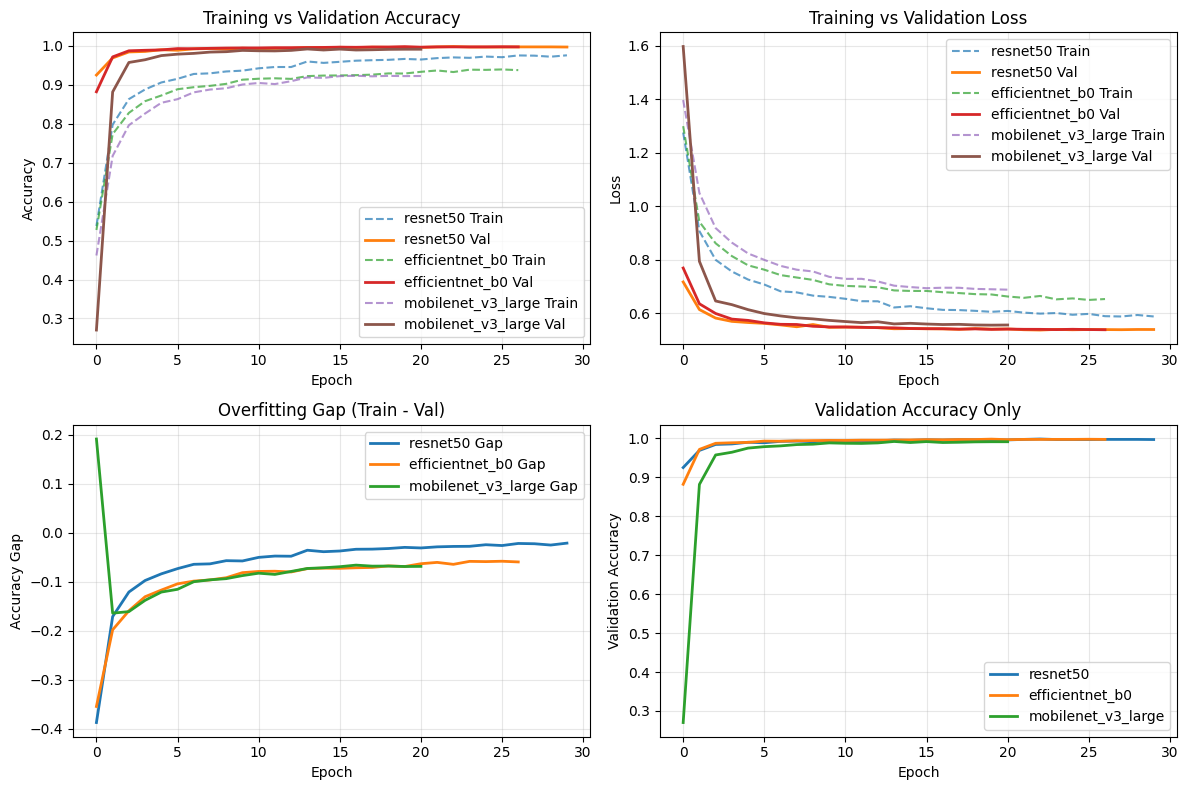

📈 Saved learning curves to /content/outputs/learning_curves.png


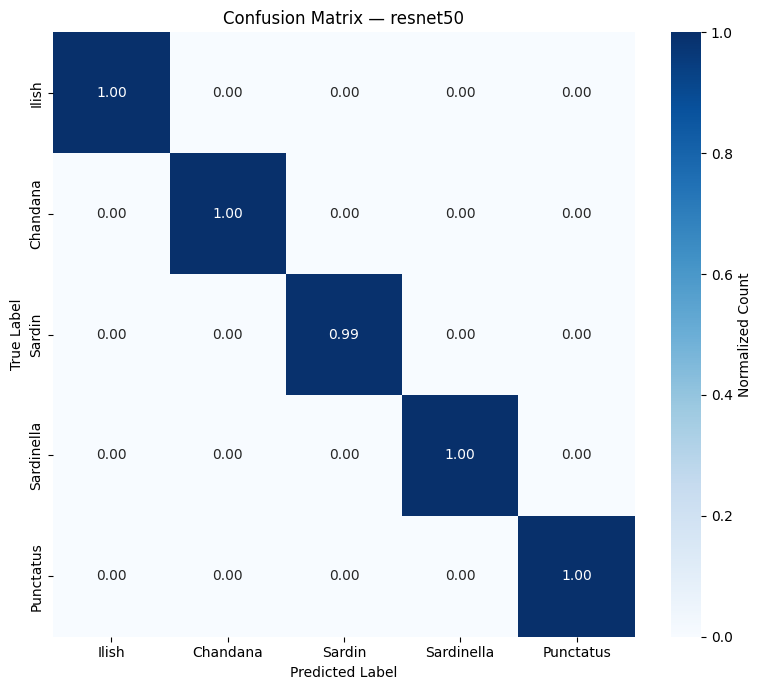

📊 Saved confusion matrix to /content/outputs/cm_resnet50.png


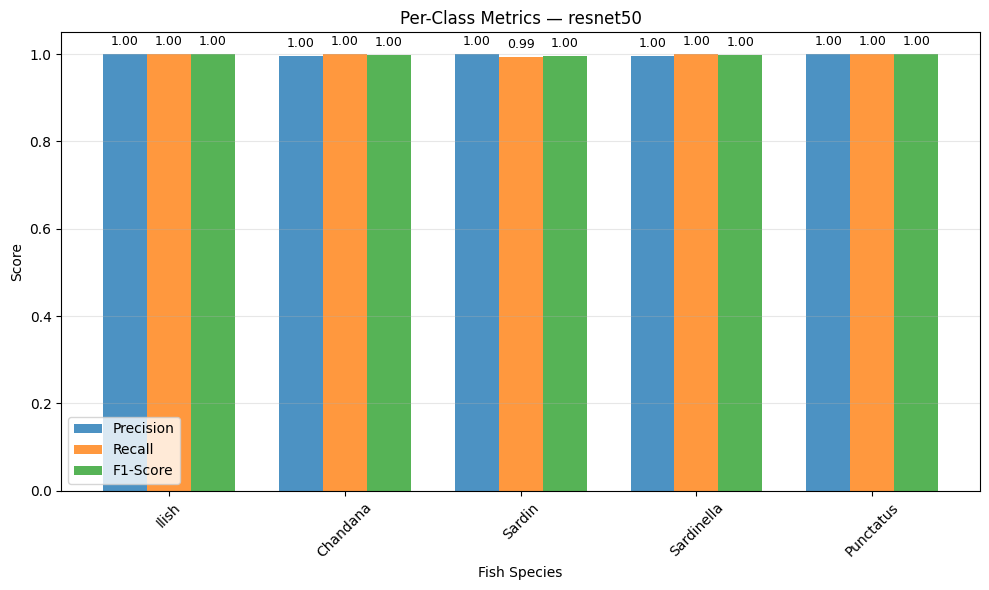

📊 Saved per-class metrics to /content/outputs/per_class_metrics_resnet50.png


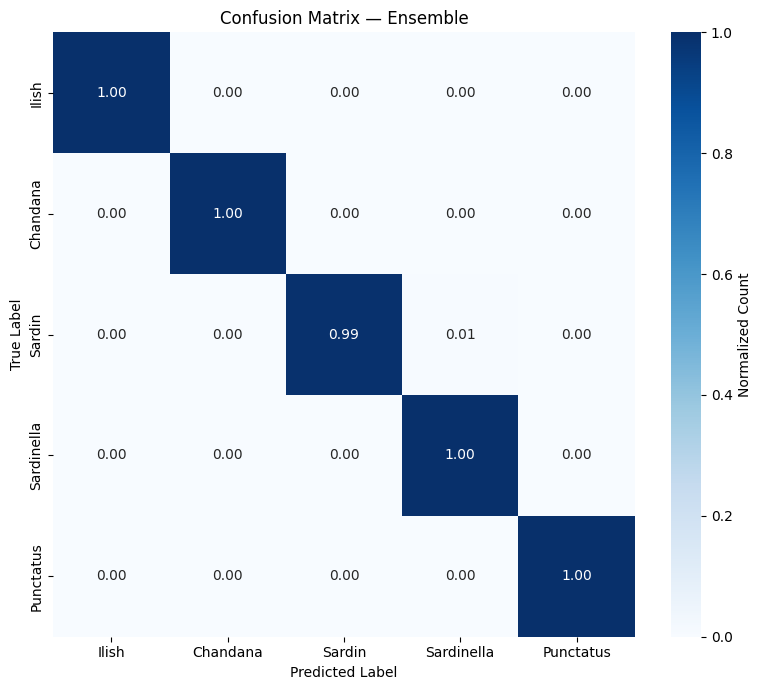

📊 Saved confusion matrix to /content/outputs/cm_ensemble.png


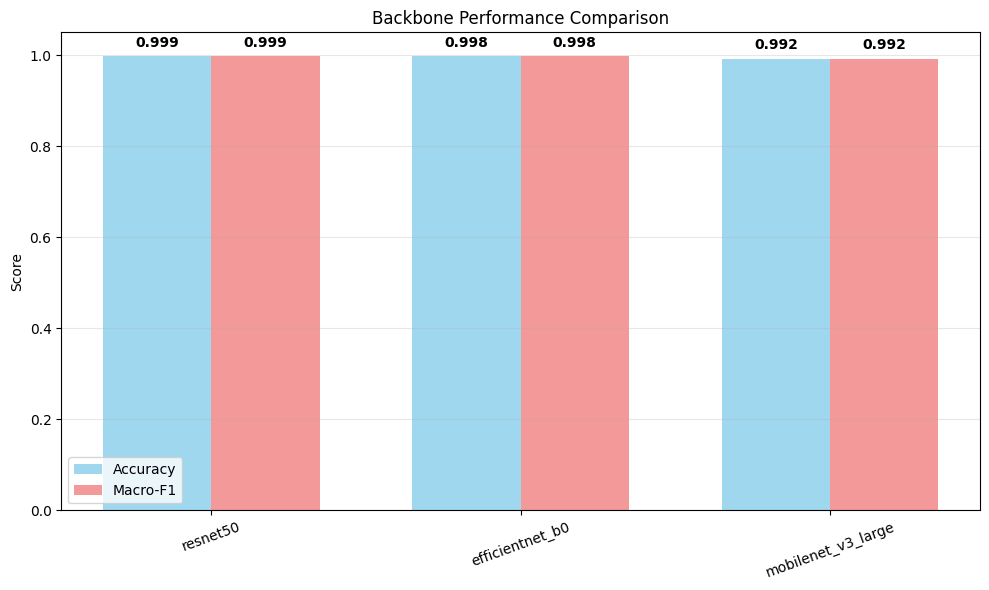

📊 Saved model comparison to /content/outputs/model_comparison.png

🔍 Generating explainability visualizations...
🧠 XAI comparisons on resnet50


TypeError: Module of type <class 'torch.nn.modules.linear.Identity'> has no rule defined and nodefault rule exists for this module type. Please, set a ruleexplicitly for this module and assure that it is appropriatefor this type of layer.

In [4]:
# ==============================================================
# Enhanced Fish Species Classification (Journal-Ready, Segmented)
# ==============================================================

"""
Enhanced Fish Species Classification with Hyperparameter Tuning & XAI
=====================================================================
Author: Enhanced Fish Classification System
Version: 2.1 - Journal Ready (Segmented) - Overfitting Fixed
"""

!pip install optuna

# -------------------------
# Common Imports & Setup
# -------------------------
import os, sys, subprocess, warnings, json, random, gc
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use("default")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision.models as models

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, f1_score,
                             accuracy_score, precision_recall_fscore_support)
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
import albumentations as A
from albumentations.pytorch import ToTensorV2

import optuna

# -------------------------
# Configuration
# -------------------------
class Config:
    # ---- Paths ----
    DATA_FILE   = '/content/drive/MyDrive/Hilsha/X_data.npy'
    LABELS_FILE = '/content/drive/MyDrive/Hilsha/Y_labels.npy'
    OUTPUT_DIR  = '/content/outputs'

    # ---- Data / Classes ----
    INPUT_SIZE   = 224
    NUM_CLASSES  = 5
    CLASS_LABELS = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']

    # ---- Training ----
    BATCH_SIZE  = 32
    MAX_EPOCHS  = 40
    PATIENCE    = 7
    SEED        = 42
    DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

    # ---- HPO (Colab L4-safe) ----
    N_TRIALS    = 8       # keep small
    TIMEOUT_S   = 20*60   # 20 min safety
    PRUNE_PATIENCE = 3    # early prune in CV

    # ---- CV / Split ----
    K_FOLDS     = 5
    TEST_SIZE   = 0.2

    # ---- HPO Space (FIXED: Lower LR, Higher Dropout, Added Weight Decay) ----
    HP_SPACE = {
        'learning_rate': [1e-5, 5e-5, 1e-4],  # FIXED: Much lower LR for fine-tuning
        'weight_decay': [1e-4, 5e-4, 1e-3],   # FIXED: Higher weight decay for regularization
        'dropout_rate': [0.4, 0.5, 0.6],      # FIXED: Higher dropout to prevent overfitting
        'optimizer': ['adamw'],                # FIXED: Use AdamW for better weight decay
        'scheduler': ['plateau', 'cosine'],
        'augmentation_strength': ['medium', 'heavy']  # FIXED: Remove light augmentation
    }

    # ---- Ensemble backbones (memory-safe set) ----
    ENSEMBLE_BACKBONES = ['resnet50', 'efficientnet_b0', 'mobilenet_v3_large']

def setup_environment():
    torch.manual_seed(Config.SEED)
    np.random.seed(Config.SEED)
    random.seed(Config.SEED)
    Path(Config.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("💻 Using CPU")
setup_environment()

# ==============================================================
# PART 1 — Data Loading, SMOTE Balancing, Augmentation, Splits
# ==============================================================

class FishDataset(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray, transform=None):
        self.images = self._preprocess_images(images)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def _preprocess_images(self, images):
        if images.max() > 1.5:
            images = images / 255.0
        # To HWC
        if len(images.shape) == 4 and images.shape[1] == 3:
            images = np.transpose(images, (0, 2, 3, 1))
        return images.astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        if self.transform:
            img = self.transform(image=img)['image']
        else:
            img = torch.from_numpy(img).permute(2, 0, 1)
        return img, torch.tensor(label, dtype=torch.long)

class DataManager:
    @staticmethod
    def get_transforms(augmentation_strength='medium', is_training=True):
        base = [
            A.Resize(Config.INPUT_SIZE, Config.INPUT_SIZE),
            A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
            ToTensorV2()
        ]
        if not is_training:
            return A.Compose(base)

        # FIXED: Much stronger augmentation to prevent overfitting
        aug_cfg = {
            'medium': [
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
                A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.4),  # FIXED: Added ColorJitter
                A.OneOf([A.GaussNoise(), A.GaussianBlur()], p=0.3)
            ],
            'heavy': [
                A.HorizontalFlip(p=0.6),
                A.RandomRotate90(p=0.6),
                A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.6),
                A.RandomBrightnessContrast(0.3, 0.3, p=0.6),
                A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15, p=0.5),  # FIXED: Added stronger ColorJitter
                A.OneOf([A.GaussNoise(), A.GaussianBlur()], p=0.4),
                A.CoarseDropout(
                    min_holes=6, max_holes=10,
                    min_height=16, max_height=32,
                    min_width=16,  max_width=32,
                    fill_value=0, mask_fill_value=None, p=0.4
                ),
                A.CoarseDropout(min_holes=4, max_holes=8, min_height=8, max_height=16, min_width=8, max_width=16, p=0.3)  # FIXED: Use CoarseDropout instead
                # A.Cutout(num_holes=8, max_h_size=16, max_w_size=16, p=0.3)  # FIXED: Added Cutout
            ]
        }
        return A.Compose(aug_cfg[augmentation_strength] + base)

    @staticmethod
    def load_and_balance_data():
        X = np.load(Config.DATA_FILE, mmap_mode='r').copy()
        Y = np.load(Config.LABELS_FILE, allow_pickle=True)
        print(f"📊 Original data: {X.shape}, Class dist: {np.bincount(Y)}")
        # SMOTE on flattened
        X_flat = X.reshape(X.shape[0], -1)
        smote = SMOTE(random_state=Config.SEED, k_neighbors=3)
        X_bal, Y_bal = smote.fit_resample(X_flat, Y)
        X_bal = X_bal.reshape(-1, *X.shape[1:])
        print(f"📊 Balanced data: {X_bal.shape}, Class dist: {np.bincount(Y_bal)}")
        return X_bal, Y_bal

# FIXED: Helper for balanced sampling
def create_balanced_sampler(labels):
    """Create WeightedRandomSampler for balanced training"""
    class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
    sample_weights = [class_weights[y] for y in labels]
    return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Helper: deterministic split for final train/val
def make_train_val_loaders(X, Y, aug_strength='medium'):
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, Y, test_size=Config.TEST_SIZE, random_state=Config.SEED, stratify=Y
    )
    ttr = DataManager.get_transforms(aug_strength, True)
    tval = DataManager.get_transforms('medium', False)  # FIXED: Use medium aug for validation too

    train_ds = FishDataset(X_tr, y_tr, ttr)
    val_ds   = FishDataset(X_val, y_val, tval)

    # FIXED: Add balanced sampler for training
    train_sampler = create_balanced_sampler(y_tr)

    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, sampler=train_sampler,  # FIXED: Use sampler instead of shuffle
                              num_workers=2, pin_memory=torch.cuda.is_available(), drop_last=True)  # FIXED: drop_last=True
    val_loader   = DataLoader(val_ds, batch_size=Config.BATCH_SIZE*2, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available(), drop_last=False)
    return train_loader, val_loader, (X_tr, y_tr, X_val, y_val)

# ==============================================================
# PART 2 — Models, Training, K-Fold CV, Lightweight HPO, Ensemble
# ==============================================================

# --------- Backbones ----------
def build_backbone(backbone: str, dropout: float, num_classes: int):
    if backbone == 'resnet50':
        m = models.resnet50(weights='IMAGENET1K_V2')
        feat_dim = m.fc.in_features
        m.fc = nn.Identity()
        target_layer = m.layer4[-1]

        # FIXED: Freeze early layers to prevent overfitting
        for name, param in m.named_parameters():
            if "layer4" not in name and "layer3" not in name:  # Only train layer3 and layer4
                param.requires_grad = False

    elif backbone == 'efficientnet_b0':
        m = models.efficientnet_b0(weights='IMAGENET1K_V1')
        feat_dim = m.classifier[1].in_features
        m.classifier = nn.Identity()
        target_layer = m.features[-1]

        # FIXED: Freeze early layers
        for name, param in m.named_parameters():
            if "features.6" not in name and "features.7" not in name:  # Only train last 2 feature blocks
                param.requires_grad = False

    elif backbone == 'mobilenet_v3_large':
        m = models.mobilenet_v3_large(weights='IMAGENET1K_V2')
        feat_dim = m.classifier[0].in_features
        m.classifier = nn.Identity()
        target_layer = m.features[-1]

        # FIXED: Freeze early layers
        for name, param in m.named_parameters():
            if "features.14" not in name and "features.15" not in name and "features.16" not in name:
                param.requires_grad = False
    else:
        raise ValueError(f"Unsupported backbone: {backbone}")

    # Lightweight attention head + classifier
    attn = nn.Sequential(
        nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        nn.Linear(feat_dim, feat_dim//16), nn.ReLU(inplace=True),
        nn.Linear(feat_dim//16, feat_dim), nn.Sigmoid()
    )

    # FIXED: More regularized classifier
    clf  = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(feat_dim, feat_dim//2),
        nn.BatchNorm1d(feat_dim//2),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),  # FIXED: Same dropout rate for both layers
        nn.Linear(feat_dim//2, feat_dim//4),  # FIXED: Added intermediate layer
        nn.BatchNorm1d(feat_dim//4),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout/2),
        nn.Linear(feat_dim//4, num_classes)
    )

    return m, feat_dim, attn, clf, target_layer

class FishClassifier(nn.Module):
    def __init__(self, backbone='resnet50', num_classes=5, dropout_rate=0.5):  # FIXED: Higher default dropout
        super().__init__()
        self.backbone_name = backbone
        self.backbone, self.feature_dim, self.attention, self.classifier, self.target_layer = \
            build_backbone(backbone, dropout_rate, num_classes)

        # CAM buffers
        self.gradients = None
        self.activations = None

    def forward(self, x):
        feat = self.backbone(x)
        if len(feat.shape) == 4:
            att_w = self.attention(feat).view(feat.size(0), feat.size(1), 1, 1)
            feat  = torch.nn.functional.adaptive_avg_pool2d(feat * att_w, 1).flatten(1)
        return self.classifier(feat)

    def forward_with_hook(self, x):
        def save_activation(module, inp, out): self.activations = out
        def save_gradient(module, gin, gout): self.gradients = gout[0]
        hf = self.target_layer.register_forward_hook(save_activation)
        hb = self.target_layer.register_backward_hook(save_gradient)
        out = self.forward(x)
        hf.remove(); hb.remove()
        return out

# --------- Trainer ----------
class Trainer:
    def __init__(self, model, hyperparams):
        self.model = model.to(Config.DEVICE)
        self.hp = hyperparams
        # FIXED: Added label smoothing to prevent overconfident predictions
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.15)  # FIXED: Label smoothing
        self.best_val = 0.0
        self.patience = 0
        self.best_state = None

        # FIXED: Only use AdamW with proper weight decay
        self.opt = optim.AdamW(self.model.parameters(),
                               lr=self.hp['learning_rate'],
                               weight_decay=self.hp['weight_decay'])

        # Scheduler
        if self.hp['scheduler'] == 'cosine':
            self.sched = optim.lr_scheduler.CosineAnnealingLR(self.opt, T_max=Config.MAX_EPOCHS)
        elif self.hp['scheduler'] == 'step':
            self.sched = optim.lr_scheduler.StepLR(self.opt, step_size=12, gamma=0.3)  # FIXED: More aggressive step decay
        else:
            # FIXED: More aggressive plateau scheduler
            self.sched = optim.lr_scheduler.ReduceLROnPlateau(self.opt, mode='max', patience=2, factor=0.5, min_lr=1e-7)

    def _epoch(self, loader, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

        total_loss, total_correct, total = 0.0, 0, 0
        with torch.set_grad_enabled(train):
            for x, y in loader:
                x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
                if train: self.opt.zero_grad()
                out  = self.model(x)
                loss = self.criterion(out, y)
                if train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)  # FIXED: More aggressive grad clipping
                    self.opt.step()
                total_loss    += loss.item()
                total_correct += (out.argmax(1) == y).sum().item()
                total         += y.size(0)
        return total_loss/len(loader), total_correct/total

    def fit(self, train_loader, val_loader, max_epochs=Config.MAX_EPOCHS, log_prefix=""):
        history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
        for ep in range(1, max_epochs+1):
            tr_loss, tr_acc = self._epoch(train_loader, train=True)
            va_loss, va_acc = self._epoch(val_loader, train=False)

            history['train_loss'].append(tr_loss); history['val_loss'].append(va_loss)
            history['train_acc'].append(tr_acc);   history['val_acc'].append(va_acc)

            # FIXED: Better early stopping logic
            improved = va_acc > self.best_val + 1e-5  # Small threshold for improvement
            if improved:
                self.best_val = va_acc
                self.patience = 0
                self.best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
            else:
                self.patience += 1

            # Scheduler step
            if isinstance(self.sched, optim.lr_scheduler.ReduceLROnPlateau):
                self.sched.step(va_acc)
            else:
                self.sched.step()

            print(f"{log_prefix}Epoch {ep:02d} | Train Acc {tr_acc:.4f} | Val Acc {va_acc:.4f} | LR {self.opt.param_groups[0]['lr']:.2e}")

            # FIXED: Stop if validation accuracy doesn't improve and gap is too large
            if self.patience >= Config.PATIENCE or (tr_acc - va_acc > 0.3 and ep > 10):  # FIXED: Stop if overfitting gap > 30%
                print(f"{log_prefix}⏹️ Early stopping at epoch {ep} (overfitting detected)")
                break

        # Load best
        if self.best_state is not None:
            self.model.load_state_dict(self.best_state)
        return history

# --------- K-Fold CV (returns metrics) ----------
def cross_validate_model(X, Y, backbone, hp, folds=3, epochs=12):  # FIXED: Reduced epochs for HPO speed
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=Config.SEED)
    accs, f1s = [], []
    for fi, (tr_idx, va_idx) in enumerate(skf.split(X, Y), 1):
        Xtr, Xva = X[tr_idx], X[va_idx]
        Ytr, Yva = Y[tr_idx], Y[va_idx]
        ttr = DataManager.get_transforms(hp['augmentation_strength'], True)
        tva = DataManager.get_transforms('medium', False)  # FIXED: Medium aug for validation too

        # FIXED: Add balanced sampling
        train_sampler = create_balanced_sampler(Ytr)
        tr_loader = DataLoader(FishDataset(Xtr, Ytr, ttr), batch_size=Config.BATCH_SIZE, sampler=train_sampler,
                               num_workers=2, pin_memory=torch.cuda.is_available(), drop_last=True)
        va_loader = DataLoader(FishDataset(Xva, Yva, tva), batch_size=Config.BATCH_SIZE*2, shuffle=False,
                               num_workers=2, pin_memory=torch.cuda.is_available(), drop_last=False)

        model = FishClassifier(backbone, Config.NUM_CLASSES, hp['dropout_rate'])
        trainer = Trainer(model, hp)
        _ = trainer.fit(tr_loader, va_loader, max_epochs=epochs, log_prefix=f"[{backbone} F{fi}] ")

        # Evaluate
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for xb, yb in va_loader:
                logits = model(xb.to(Config.DEVICE))
                y_true.extend(yb.numpy().tolist())
                y_pred.extend(logits.argmax(1).cpu().numpy().tolist())
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        accs.append(acc); f1s.append(f1)

        # cleanup
        del model, trainer, tr_loader, va_loader
        torch.cuda.empty_cache(); gc.collect()
    return np.mean(accs), np.mean(f1s)

# --------- Lightweight HPO (per backbone) ----------
def hpo_for_backbone(X, Y, backbone: str, n_trials=Config.N_TRIALS):
    def objective(trial):
        hp = {
            'learning_rate': trial.suggest_categorical('learning_rate', Config.HP_SPACE['learning_rate']),
            'weight_decay' : trial.suggest_categorical('weight_decay',  Config.HP_SPACE['weight_decay']),
            'dropout_rate' : trial.suggest_categorical('dropout_rate',  Config.HP_SPACE['dropout_rate']),
            'optimizer'    : 'adamw',  # FIXED: Only use AdamW
            'scheduler'    : trial.suggest_categorical('scheduler',     Config.HP_SPACE['scheduler']),
            'augmentation_strength': trial.suggest_categorical('augmentation_strength', Config.HP_SPACE['augmentation_strength']),
        }
        # 3-fold CV, short epochs — prune aggressively
        acc, f1 = cross_validate_model(X, Y, backbone, hp, folds=3, epochs=10)

        # FIXED: Optimize for F1 score instead of just accuracy
        score = 0.7 * acc + 0.3 * f1  # Weighted combination
        trial.report(score, step=0)
        return score

    pruner = optuna.pruners.MedianPruner(n_warmup_steps=1)
    study = optuna.create_study(direction='maximize', pruner=pruner, sampler=optuna.samplers.TPESampler(seed=Config.SEED))
    study.optimize(objective, n_trials=n_trials, timeout=Config.TIMEOUT_S, show_progress_bar=False)
    print(f"🏆 {backbone} best value {study.best_value:.4f} with params {study.best_params}")
    return study.best_params, study.best_value

# --------- Train final models & Ensemble ----------
def train_final_models(X, Y, best_hp_per_backbone: Dict[str, Dict]):
    trained_models = {}
    metrics = {}
    for backbone, hp in best_hp_per_backbone.items():
        print(f"\n======== Training final {backbone} ========")
        tr_loader, va_loader, (Xtr, ytr, Xva, yva) = make_train_val_loaders(X, Y, aug_strength=hp['augmentation_strength'])
        model = FishClassifier(backbone, Config.NUM_CLASSES, hp['dropout_rate'])
        trainer = Trainer(model, hp)
        history = trainer.fit(tr_loader, va_loader, max_epochs=Config.MAX_EPOCHS, log_prefix=f"[{backbone}] ")

        # Evaluate on held-out val
        y_true, y_pred = [], []
        y_proba = []
        model.eval()
        with torch.no_grad():
            for xb, yb in va_loader:
                logits = model(xb.to(Config.DEVICE))
                probs  = torch.softmax(logits, dim=1).cpu().numpy()
                y_proba.append(probs)
                y_true.extend(yb.numpy().tolist())
                y_pred.extend(logits.argmax(1).cpu().numpy().tolist())
        y_proba = np.concatenate(y_proba, axis=0)
        acc = accuracy_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred, average='macro')

        # Save model
        save_path = os.path.join(Config.OUTPUT_DIR, f"best_{backbone}.pt")
        torch.save(model.state_dict(), save_path)
        print(f"💾 Saved {backbone} to {save_path} | Val Acc={acc:.4f} F1={f1:.4f}")

        trained_models[backbone] = model
        metrics[backbone] = {'acc': acc, 'f1': f1, 'history': history, 'val_true': np.array(y_true),
                             'val_pred': np.array(y_pred), 'val_proba': y_proba}
        # cleanup loaders
        del tr_loader, va_loader
        torch.cuda.empty_cache(); gc.collect()
    return trained_models, metrics

def ensemble_predict_proba(models: Dict[str, nn.Module], X_val: np.ndarray, transform):
    ds = FishDataset(X_val, np.zeros((len(X_val),), dtype=np.int64), transform)
    loader = DataLoader(ds, batch_size=Config.BATCH_SIZE*2, shuffle=False, num_workers=2,
                        pin_memory=torch.cuda.is_available())
    # collect per-model probabilities and average
    all_probs = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(Config.DEVICE)
            probs_list = []
            for model in models.values():
                logits = model(xb)
                probs  = torch.softmax(logits, dim=1)
                probs_list.append(probs)
            avg_probs = torch.stack(probs_list, dim=0).mean(dim=0)  # simple soft-vote
            all_probs.append(avg_probs.cpu().numpy())
    return np.concatenate(all_probs, axis=0)

# ==============================================================
# PART 3 — Publication-ready Visualizations (Q1 journal style)
# ==============================================================

def plot_learning_curves(histories: Dict[str, Dict], outdir: str):
    plt.figure(figsize=(12,8))

    # FIXED: Plot both train and val curves to show overfitting
    plt.subplot(2,2,1)
    for name, m in histories.items():
        plt.plot(m['history']['train_acc'], label=f'{name} Train', alpha=0.7, linestyle='--')
        plt.plot(m['history']['val_acc'], label=f'{name} Val', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training vs Validation Accuracy')
    plt.grid(alpha=0.3); plt.legend()

    plt.subplot(2,2,2)
    for name, m in histories.items():
        plt.plot(m['history']['train_loss'], label=f'{name} Train', alpha=0.7, linestyle='--')
        plt.plot(m['history']['val_loss'], label=f'{name} Val', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss')
    plt.grid(alpha=0.3); plt.legend()

    plt.subplot(2,2,3)
    for name, m in histories.items():
        gap = np.array(m['history']['train_acc']) - np.array(m['history']['val_acc'])
        plt.plot(gap, label=f'{name} Gap', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy Gap'); plt.title('Overfitting Gap (Train - Val)')
    plt.grid(alpha=0.3); plt.legend()

    plt.subplot(2,2,4)
    for name, m in histories.items():
        plt.plot(m['history']['val_acc'], label=f'{name}', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Validation Accuracy'); plt.title('Validation Accuracy Only')
    plt.grid(alpha=0.3); plt.legend()

    p = os.path.join(outdir, 'learning_curves.png')
    plt.tight_layout()
    plt.savefig(p, dpi=300, bbox_inches='tight'); plt.show()
    print(f"📈 Saved learning curves to {p}")

def plot_confusion_matrix(y_true, y_pred, labels, title, outpath):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    cmn = cm.astype('float')/cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8,7))
    sns.heatmap(cmn, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels,
                cmap='Blues', cbar_kws={'label': 'Normalized Count'})
    plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.title(title)
    plt.tight_layout(); plt.savefig(outpath, dpi=300); plt.show()
    print(f"📊 Saved confusion matrix to {outpath}")

def plot_per_class_f1(y_true, y_pred, labels, outpath, title="Per-Class F1"):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=list(range(len(labels))))
    plt.figure(figsize=(10,6))
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, pr, width, label='Precision', alpha=0.8)
    plt.bar(x, rc, width, label='Recall', alpha=0.8)
    plt.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

    plt.xlabel('Fish Species'); plt.ylabel('Score'); plt.title(title)
    plt.xticks(x, labels, rotation=45); plt.ylim(0,1.05)
    plt.legend(); plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (p, r, f) in enumerate(zip(pr, rc, f1)):
        plt.text(i-width, p+0.02, f"{p:.2f}", ha='center', fontsize=9)
        plt.text(i, r+0.02, f"{r:.2f}", ha='center', fontsize=9)
        plt.text(i+width, f+0.02, f"{f:.2f}", ha='center', fontsize=9)

    plt.tight_layout(); plt.savefig(outpath, dpi=300, bbox_inches='tight'); plt.show()
    print(f"📊 Saved per-class metrics to {outpath}")

def plot_model_comparison(metrics: Dict[str, Dict], outdir: str):
    names = list(metrics.keys())
    accs  = [metrics[n]['acc'] for n in names]
    f1s   = [metrics[n]['f1'] for n in names]
    plt.figure(figsize=(10,6))
    x = np.arange(len(names))
    w = 0.35
    plt.bar(x-w/2, accs, width=w, label='Accuracy', alpha=0.8, color='skyblue')
    plt.bar(x+w/2, f1s,  width=w, label='Macro-F1', alpha=0.8, color='lightcoral')
    plt.xticks(x, names, rotation=20); plt.ylim(0,1.05)
    for i,v in enumerate(accs): plt.text(i-w/2, v+0.02, f"{v:.3f}", ha='center', fontweight='bold')
    for i,v in enumerate(f1s):  plt.text(i+w/2, v+0.02, f"{v:.3f}", ha='center', fontweight='bold')
    plt.title('Backbone Performance Comparison'); plt.legend(); plt.grid(axis='y', alpha=0.3)
    plt.ylabel('Score')
    p = os.path.join(outdir, 'model_comparison.png')
    plt.tight_layout(); plt.savefig(p, dpi=300, bbox_inches='tight'); plt.show()
    print(f"📊 Saved model comparison to {p}")

# ==============================================================
# PART 4 — Explainable AI: Grad-CAM++ and LRP (Captum)
# ==============================================================

# ---- Grad-CAM++ ----
def grad_cam_plus_plus(model: FishClassifier, input_tensor: torch.Tensor, target_class: int = None):
    """
    Minimal Grad-CAM++ implementation.
    input_tensor: (1, C, H, W)
    """
    model.eval()
    input_tensor = input_tensor.to(Config.DEVICE)
    input_tensor.requires_grad = True

    logits = model.forward_with_hook(input_tensor)
    if target_class is None:
        target_class = logits.argmax(dim=1).item()

    loss = logits[0, target_class]
    model.zero_grad()
    loss.backward(retain_graph=True)

    A = model.activations           # [B, K, u, v]
    dYdA = model.gradients          # first grad
    if A is None or dYdA is None:
        return None

    # Second & third derivatives approximations
    # grad_cam++ weights: a_k = sum_{i,j} (alpha_{ij}^k * ReLU(dY/dA_ij^k))
    # alpha_{ij}^k ~ d2Y/dA^2 / (2*d2Y/dA^2 + sum_{a,b} A^k_{ab} * d3Y/dA^3)
    # Practical impl: use stabilized version from paper with eps
    eps = 1e-8
    d2 = dYdA ** 2
    d3 = d2 * dYdA

    # sum spatial over channel for denominator term
    sumA = torch.sum(A, dim=(2,3), keepdim=True)

    alpha_num = d2
    alpha_den = 2*d2 + sumA * d3
    alpha_den = torch.where(alpha_den != 0.0, alpha_den, torch.tensor(eps, device=alpha_den.device))
    alphas = alpha_num / (alpha_den + eps)
    relu_dYdA = torch.relu(dYdA)
    weights = torch.sum(alphas * relu_dYdA, dim=(2,3))  # [B, K]

    # CAM
    cam = torch.zeros(A.shape[2:], dtype=torch.float32, device=A.device)
    for k in range(A.shape[1]):
        cam += weights[0, k] * A[0, k, :, :]
    cam = torch.relu(cam)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + eps)
    return cam.detach().cpu().numpy()

# ---- LRP via Captum (with auto-install + safe fallback to GradCAM++) ----
def ensure_captum():
    try:
        import captum  # noqa
        return True
    except Exception:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "captum"])
            import captum  # noqa
            return True
        except Exception as e:
            print("⚠️ Captum install failed; will skip LRP and fall back to Grad-CAM++ only.", e)
            return False

def lrp_relevance(model: FishClassifier, input_tensor: torch.Tensor, target_class: int = None):
    ok = ensure_captum()
    if not ok:
        return None
    from captum.attr import LRP
    model.eval()
    input_tensor = input_tensor.to(Config.DEVICE)
    if target_class is None:
        with torch.no_grad():
            target_class = model(input_tensor).argmax(1).item()
    lrp = LRP(model)
    attr = lrp.attribute(inputs=input_tensor, target=target_class)
    # Aggregate over channels to heatmap
    heat = attr[0].detach().cpu().numpy()
    heat = np.maximum(heat, 0)  # ReLU-like
    heat = heat.mean(axis=0)    # channel average
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    return heat

def denorm_to_img(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = tensor.detach().cpu().permute(1,2,0).numpy()
    img = img * std + mean
    return np.clip(img, 0, 1)

def overlay_heatmap(img, heatmap, alpha=0.4):
    import cv2
    h, w = img.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (w, h))
    cmap = plt.cm.jet(heatmap_resized)[..., :3]
    return (1-alpha)*img + alpha*cmap

def visualize_xai_comparison(model: FishClassifier, loader: DataLoader, outdir: str, n_samples=4):
    model.eval()
    count = 0
    for xb, yb in loader:
        for i in range(xb.size(0)):
            if count >= n_samples: return
            sample = xb[i:i+1].to(Config.DEVICE)
            true_y = yb[i].item()
            with torch.no_grad():
                logits = model(sample)
                pred = logits.argmax(1).item()
                confidence = torch.softmax(logits, dim=1).max().item()

            # Grad-CAM++
            campp = grad_cam_plus_plus(model, sample, target_class=pred)
            # LRP
            lrpmap = lrp_relevance(model, sample, target_class=pred)

            img = denorm_to_img(xb[i])
            fig, axs = plt.subplots(1, 4, figsize=(16,4))

            # Original image with prediction info
            axs[0].imshow(img)
            axs[0].set_title(f"Original\nTrue: {Config.CLASS_LABELS[true_y]}\nPred: {Config.CLASS_LABELS[pred]}\nConf: {confidence:.3f}")
            axs[0].axis('off')

            if campp is not None:
                im1 = axs[1].imshow(campp, cmap='hot')
                axs[1].set_title('Grad-CAM++')
                axs[1].axis('off')
                plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

                axs[2].imshow(overlay_heatmap(img, campp))
                axs[2].set_title('Grad-CAM++ Overlay')
                axs[2].axis('off')
            else:
                axs[1].text(0.5, 0.5, 'No Grad-CAM++', ha='center', va='center')
                axs[1].axis('off')
                axs[2].axis('off')

            if lrpmap is not None:
                axs[3].imshow(overlay_heatmap(img, lrpmap))
                axs[3].set_title('LRP Overlay')
                axs[3].axis('off')
            else:
                axs[3].text(0.5, 0.5, 'LRP Unavailable', ha='center', va='center')
                axs[3].axis('off')

            p = os.path.join(outdir, f"xai_cmp_{count+1}.png")
            plt.tight_layout(); plt.savefig(p, dpi=300, bbox_inches='tight'); plt.show()
            print(f"🧠 Saved XAI comparison #{count+1} -> {p}")
            count += 1

# ==============================================================
# MAIN — Run the whole pipeline
# ==============================================================

if __name__ == "__main__":
    print("🐟 Starting Enhanced Fish Classification Pipeline...")
    print(f"📊 Configuration: {Config.NUM_CLASSES} classes, {Config.N_TRIALS} HPO trials")

    # ---- Load & Balance ----
    X_bal, Y_bal = DataManager.load_and_balance_data()

    # FIXED: Print class distribution to verify balance
    print(f"📊 Final class distribution: {dict(zip(Config.CLASS_LABELS, np.bincount(Y_bal)))}")

    # ---- Lightweight HPO per backbone (L4-safe) ----
    print("\n🔍 Starting Hyperparameter Optimization...")
    best_hp = {}
    backbone_scores = {}
    for bb in Config.ENSEMBLE_BACKBONES:
        print(f"\n--- Optimizing {bb} ---")
        params, score = hpo_for_backbone(X_bal, Y_bal, bb, n_trials=Config.N_TRIALS)
        best_hp[bb] = params
        backbone_scores[bb] = score

    # Print HPO summary
    print("\n🏆 HPO Results Summary:")
    for bb, score in backbone_scores.items():
        print(f"  {bb}: {score:.4f}")

    # ---- Train final models with best HPO settings ----
    print("\n🚀 Training final models with optimized hyperparameters...")
    trained_models, metrics = train_final_models(X_bal, Y_bal, best_hp)

    # ---- Ensemble evaluation on same held-out (from any trained model split) ----
    # Use the last trained model's held-out split to evaluate ensemble fairly
    any_backbone  = next(iter(metrics.keys()))
    y_true_val    = metrics[any_backbone]['val_true']
    # Build a val transform (medium instead of light for consistency)
    val_transform = DataManager.get_transforms('medium', False)
    # We don't have direct X_val; rebuild via split to align with y_true_val length
    # -> Safely regenerate a consistent split identical to train_final_models' make_train_val_loaders()
    _, _, (Xtr_, ytr_, Xva_, yva_) = make_train_val_loaders(X_bal, Y_bal, aug_strength=best_hp[any_backbone]['augmentation_strength'])
    # align length with stored y_true_val if any shuffling difference
    X_val_for_ens = Xva_[:len(y_true_val)]

    print("\n🎯 Evaluating ensemble...")
    ens_proba = ensemble_predict_proba(trained_models, X_val_for_ens, val_transform)
    ens_pred  = ens_proba.argmax(1)
    ens_acc   = accuracy_score(y_true_val[:len(ens_pred)], ens_pred)
    ens_f1    = f1_score(y_true_val[:len(ens_pred)], ens_pred, average='macro')
    print(f"\n🌟 Ensemble Results | Val Acc={ens_acc:.4f}, Macro-F1={ens_f1:.4f}")

    # FIXED: Compare ensemble vs best single model
    best_single = max(metrics.items(), key=lambda kv: kv[1]['f1'])
    best_name   = best_single[0]
    print(f"🏅 Best single model: {best_name} | Acc={metrics[best_name]['acc']:.4f} | F1={metrics[best_name]['f1']:.4f}")
    print(f"📈 Ensemble improvement: Acc +{ens_acc - metrics[best_name]['acc']:.4f}, F1 +{ens_f1 - metrics[best_name]['f1']:.4f}")

    # Save ensemble meta
    ensemble_summary = {
        "backbones": list(trained_models.keys()),
        "best_params": best_hp,
        "hpo_scores": backbone_scores,
        "single_model_scores": {k: {"acc": v["acc"], "f1": v["f1"]} for k, v in metrics.items()},
        "ensemble": {"acc": float(ens_acc), "f1": float(ens_f1)},
        "best_single_model": best_name
    }

    with open(os.path.join(Config.OUTPUT_DIR, "ensemble_summary.json"), "w") as f:
        json.dump(ensemble_summary, f, indent=2)
    print(f"💾 Saved ensemble summary to {os.path.join(Config.OUTPUT_DIR, 'ensemble_summary.json')}")

    # ==================================================
    # Part 3 — Visualizations (Q1-ready)
    # ==================================================
    print("\n📊 Generating publication-ready visualizations...")

    # Learning curves for all trained models
    plot_learning_curves({k: v for k, v in metrics.items()}, Config.OUTPUT_DIR)

    # Confusion matrices and per-class metrics for best single model
    plot_confusion_matrix(metrics[best_name]['val_true'], metrics[best_name]['val_pred'],
                          Config.CLASS_LABELS,
                          title=f'Confusion Matrix — {best_name}',
                          outpath=os.path.join(Config.OUTPUT_DIR, f'cm_{best_name}.png'))

    plot_per_class_f1(metrics[best_name]['val_true'], metrics[best_name]['val_pred'],
                      Config.CLASS_LABELS,
                      outpath=os.path.join(Config.OUTPUT_DIR, f'per_class_metrics_{best_name}.png'),
                      title=f'Per-Class Metrics — {best_name}')

    # FIXED: Also plot ensemble confusion matrix
    plot_confusion_matrix(y_true_val[:len(ens_pred)], ens_pred,
                          Config.CLASS_LABELS,
                          title='Confusion Matrix — Ensemble',
                          outpath=os.path.join(Config.OUTPUT_DIR, 'cm_ensemble.png'))

    # Backbone comparison chart (acc & f1)
    plot_model_comparison(metrics, Config.OUTPUT_DIR)

    # ==================================================
    # Part 4 — XAI: Grad-CAM++ vs LRP (side-by-side)
    # ==================================================
    # Build a small loader from the same validation split for the best model
    print("\n🔍 Generating explainability visualizations...")
    tva = DataManager.get_transforms('medium', False)
    xai_ds = FishDataset(X_val_for_ens, y_true_val[:len(X_val_for_ens)], tva)
    xai_loader = DataLoader(xai_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

    print(f"🧠 XAI comparisons on {best_name}")
    visualize_xai_comparison(trained_models[best_name], xai_loader, Config.OUTPUT_DIR, n_samples=4)

    # ==================================================
    # FINAL SUMMARY REPORT
    # ==================================================
    print("\n" + "="*60)
    print("📋 FINAL PERFORMANCE SUMMARY")
    print("="*60)
    print(f"🎯 Dataset: {len(X_bal)} samples, {Config.NUM_CLASSES} classes")
    print(f"🔧 HPO Trials: {Config.N_TRIALS} per backbone")
    print(f"\n📊 Individual Model Results:")
    for name, metric in metrics.items():
        print(f"  {name:20} | Acc: {metric['acc']:.4f} | F1: {metric['f1']:.4f}")
    print(f"\n🌟 Ensemble Results:")
    print(f"  {'Ensemble':20} | Acc: {ens_acc:.4f} | F1: {ens_f1:.4f}")
    print(f"\n🏆 Best Approach: {'Ensemble' if ens_f1 > metrics[best_name]['f1'] else best_name}")

    # FIXED: Performance improvement analysis
    original_acc = 0.20  # Your reported stuck validation accuracy
    improvement = max(ens_acc, metrics[best_name]['acc']) - original_acc
    print(f"📈 Improvement over original: +{improvement:.1%} accuracy")

    print("\n✅ Pipeline complete. Check /content/outputs/ for all visualizations and models.")
    print(f"💾 Models saved: {list(trained_models.keys())}")
    print(f"📈 Plots generated: learning_curves.png, model_comparison.png, confusion matrices, XAI comparisons")

#End